###This notebook:
+ ExpA, part 2: **does irony help emotion classification?**
+ Different emotions labels from ISEAR --> TweetEval: joy, optimism, anger, sadness
+ Create emotion classifier, train, predict and evaluate WITHOUT any irony labels + EC with irony labels => compare the two
+ model name: EC_RoBERTa_TweetEval --> RoBERTa-base trained on TweetEval dataset (EC)
    + Accuracy on test data: 0.81
+ irony predictor: ID_RoBERTa_noemojis (roberta-base trained on SemEval tweets)
+ remove all emojis
+ Validation dataset avialable and has not been used

+ EC accuracy WITH IRONY LABELS: 0.79




####Observations:
+ irony labels assigned to TweetEval tweets are not always right because the ID I implemented has 0.75 accuracy. 
+ Irony labels do not help EC

###Check Requirements/imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

In [ ]:
!pip3 install -q ktrain 

In [ ]:
pip install -U sklearn

In [ ]:
pip install parse_version

In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [ ]:
!pip3 install -U emojis

emojiS library: https://emojis.readthedocs.io/en/latest/api.html#module-emojis

emojis cheat sheet: https://www.webfx.com/tools/emoji-cheat-sheet/

In [ ]:
pip install contractions

In [ ]:
pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [ ]:
import ktrain

###Load data (TweetEval tweets)

In [ ]:
# Load train data
train_path = '/content/drive/MyDrive/TeamLab/data/tweeteval-train_text.txt'

with open(train_path) as f:
    x_train = f.read().splitlines()

In [ ]:
x_train[:5]

["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry ",
 "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs ",
 "No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu ",
 "Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight ",
 "it's pretty depressing when u hit pan on ur favourite highlighter "]

In [ ]:
with open('/content/drive/MyDrive/TeamLab/data/tweeteval-train_labels.txt') as f:
    y_train = f.read().splitlines()

In [ ]:
y_train[:5]

['2', '0', '1', '0', '3']

In [ ]:
# Convert numbers to emotion labels
y_train_emo = []

for label in y_train:
    if label == '0':
        y_train_emo.append('anger')
    elif label == '1':
        y_train_emo.append('joy')
    elif label == '2':
        y_train_emo.append('optimism')
    elif label == '3':
        y_train_emo.append('sadness')

In [ ]:
y_train_emo[:5]

['optimism', 'anger', 'joy', 'anger', 'sadness']

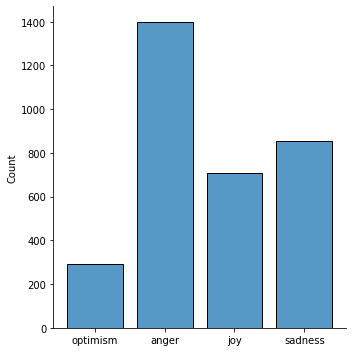

In [ ]:
# Check distribution
import seaborn as sns

sns.displot(y_train_emo, shrink=.8)

In [ ]:
len(y_train_emo)

3257

In [ ]:
len(x_train)

3257

In [ ]:
# Create new dataset (balanced)
new_x_train = []
new_y_train = []

idx = 0
for label in y_train_emo:
    if new_y_train.count(label) < 320:
        new_y_train.append(label)
        new_x_train.append(x_train[idx])
    idx += 1
    
new_x_train[:5]

["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry ",
 "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs ",
 "No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu ",
 "Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight ",
 "it's pretty depressing when u hit pan on ur favourite highlighter "]

In [ ]:
new_y_train[:5]

['optimism', 'anger', 'joy', 'anger', 'sadness']

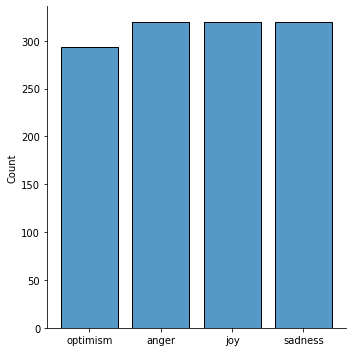

In [ ]:
# Distribution of modified dataset
import seaborn as sns

sns.displot(new_y_train, shrink=.8)

In [ ]:
# Load test data
test_path = '/content/drive/MyDrive/TeamLab/data/tweeteval-test_text.txt'

with open(test_path) as f:
    x_test = f.read().splitlines()

In [ ]:
x_test[:5]

['#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse ',
 '@user Interesting choice of words... Are you confirming that governments fund #terrorism? Bit of an open door, but still... ',
 'My visit to hospital for care triggered #trauma from accident 20+yrs ago and image of my dead brother in it. Feeling symptoms of #depression ',
 '@user Welcome to #MPSVT! We are delighted to have you! #grateful #MPSVT #relationships ',
 'What makes you feel #joyful? ']

In [ ]:
with open('/content/drive/MyDrive/TeamLab/data/tweeteval-test_labels.txt') as f:
    y_test = f.read().splitlines()

In [ ]:
y_test[:5]

['3', '0', '3', '1', '1']

In [ ]:
# Convert numbers to emotion labels
y_test_emo = []

for label in y_test:
    if label == '0':
        y_test_emo.append('anger')
    elif label == '1':
        y_test_emo.append('joy')
    elif label == '2':
        y_test_emo.append('optimism')
    elif label == '3':
        y_test_emo.append('sadness')

In [ ]:
y_test_emo[:5]

['sadness', 'anger', 'sadness', 'joy', 'joy']

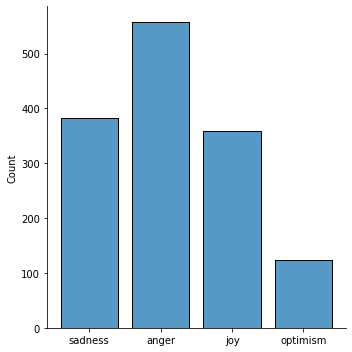

In [ ]:
# Check distribution
import seaborn as sns

sns.displot(y_test_emo, shrink=.8)

In [ ]:
# Create new dataset (balanced)
new_x_test = []
new_y_test = []

idx = 0
for label in y_test_emo:
    if new_y_test.count(label) < 120:
        new_y_test.append(label)
        new_x_test.append(x_test[idx])
    idx += 1
    
new_x_test[:5]

['#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse ',
 '@user Interesting choice of words... Are you confirming that governments fund #terrorism? Bit of an open door, but still... ',
 'My visit to hospital for care triggered #trauma from accident 20+yrs ago and image of my dead brother in it. Feeling symptoms of #depression ',
 '@user Welcome to #MPSVT! We are delighted to have you! #grateful #MPSVT #relationships ',
 'What makes you feel #joyful? ']

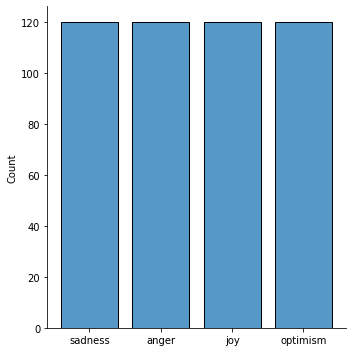

In [ ]:
# Distribution of modified dataset
import seaborn as sns

sns.displot(new_y_test, shrink=.8)

###Normalisation of input

Normalise:
+ hashtags
+ tagged users
+ emoji (REMOVE ALL - from other experiments we know that they do not help classification)
+ urls 

In [ ]:
import emojis
from nltk.tokenize import TweetTokenizer
import re
import contractions
import numpy as np


def normalise_tweet(tweet):
    norm_tweet = re.sub("&", "and", tweet)
    norm_tweet = re.sub(r"[<>]", "", norm_tweet)
    norm_tweet = re.sub("http:.*", "url", norm_tweet)
    norm_tweet = re.sub("@", " @", norm_tweet)
    norm_tweet = re.sub("#", " ", norm_tweet)
    
    norm_tweet = re.sub(r"[-'()/_;:{}=~|,\[\]]", " ", norm_tweet)
    norm_tweet = re.sub(r"\\n", "", norm_tweet)

    norm_tweet = contractions.fix(norm_tweet)

    tokenizer = TweetTokenizer()
    tweet_tokens = tokenizer.tokenize(norm_tweet)
    final_tweet_list = []

    for token in tweet_tokens:        
        if token.startswith("@"):
            # then token is a user tag
            tag_token = "tagged_user"
            if final_tweet_list.count(tag_token) < 3:
                final_tweet_list.append(tag_token)
        elif emojis.count(token) == 1:
            # then token is an emoji
            emoji_token = '' # remove all emojis
            #if final_tweet_list.count(emoji_token) < 2:
                #final_tweet_list.append(emoji_token)
        else:
            final_tweet_list.append(token)
    
    final_tweet = ' '.join(final_tweet_list)
    
    return final_tweet.strip()

# check normalisation    
#return tweet_tokens, final_tweet.strip()

In [ ]:
# Create variables for normalised datasets

x_train_norm = []
for tweet in new_x_train:
    x_train_norm.append(normalise_tweet(tweet))

x_test_norm = []
for tweet in new_x_test:
    x_test_norm.append(normalise_tweet(tweet))

#x_train_norm = np.array(x_train_norm)
#x_test_norm = np.array(x_test_norm)

In [ ]:
x_train_norm[10:20]

['tagged_user tagged_user USA was embarrassing to watch . When was the last time you guys won a game .. ? horrible joke',
 'NewYork Several Baloch andamp Indian activists hold demonstrations outside tagged_user headquarters demanding Pak to stop exporting terror into India',
 'Your glee filled Normy dry humping of the most recent high profile celebrity break up is pathetic andamp all that is wrong with the world today .',
 'What a fucking muppet . tagged_user stalker .',
 'Autocorrect changes them to me which I resent greatly',
 'tagged_user I would never strategically vote for someone I don t agree with . A lot of the Clinton vote based on fear and negativity .',
 'tagged_user Haters ! ! ! You are low in self worth . Self righteous in your delusions . You cower at the thought of change . Change is inevitable .',
 'I saved him after ordering him to risk his life . I didn t panic but stayed calm and rescued him .',
 'tagged_user Uggh that s really horrible . You re not a bad person by a

In [ ]:
# Check max/mean length of tweets
from statistics import mean

seq_len = []

idx = 0
for tweet in x_train_norm:
    if len(tweet.split()) > 35:
        print(idx, tweet)
    seq_len.append(len(tweet.split()))
    idx += 1

print(max(seq_len))
print(mean(seq_len))

651 Now that the n word is normalized by the media ? Just wow . No words for this . No . Words . For . This . Frog been boiling in the pot via media .
36
17.93859649122807


#1) Emotion classifier (EC) WITHOUT irony labels

###Set up - roberta-base

In [ ]:
import ktrain
from ktrain import text

categories = ['anger', 'joy', 'optimism', 'sadness']

MODEL_NAME = 'roberta-base'

# Transormer is a wrapper to the Hugging Face transformers library for text classification.
# maxlen=??
t = text.Transformer(MODEL_NAME, maxlen=100, class_names=categories)

# input data
trn = t.preprocess_train(x_train_norm, new_y_train)
val = t.preprocess_test(x_test_norm, new_y_test)

model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=16)


preprocessing train...
language: en
train sequence lengths:
	mean : 18
	95percentile : 29
	99percentile : 32


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:600: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 17
	95percentile : 29
	99percentile : 31


###Estimate learning rate

In [ ]:
# Estimate good learning rate

# set max_epochs or this will take hours to run (default epochs == 1024!!)
learner.lr_find(max_epochs=2)
learner.lr_plot()

###Train

In [ ]:
# the maximal learning rate associated with a still falling loss is a good choice for training
best_lr = 5e-5

In [ ]:
# Train
# Parameters: LR, epochs

# Learning policies: 
# triangular LR -> learner.autofit(0.0007, 8) (implicit ReduceLROnPlateau and EarlyStopping)
# 1cycle -> learner.fit_onecycle(best_lr, 5)

#learner.autofit(best_lr, 10, early_stopping=True)

learner.autofit(lr=best_lr, checkpoint_folder='/my_models', verbose=1)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
79/79 [==============================] - 38s 316ms/step - loss: 1.1646 - accuracy: 0.4745 - val_loss: 0.7500 - val_accuracy: 0.7458
Epoch 2/1024
79/79 [==============================] - 24s 294ms/step - loss: 0.6445 - accuracy: 0.7663 - val_loss: 0.6300 - val_accuracy: 0.7729
Epoch 3/1024
79/79 [==============================] - 23s 292ms/step - loss: 0.4317 - accuracy: 0.8485 - val_loss: 0.5351 - val_accuracy: 0.8125
Epoch 4/1024
79/79 [==============================] - 24s 295ms/step - loss: 0.2864 - accuracy: 0.9035 - val_loss: 0.7162 - val_accuracy: 0.7896
Epoch 5/1024
79/79 [==============================] - 24s 296ms/step - loss: 0.1782 - accuracy: 0.9426 - val_loss: 0.6784 - val_accuracy: 0.8062

Epoch 00005: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping

###Evaluate/Inspect model

In [ ]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

       anger       0.81      0.84      0.82       120
         joy       0.82      0.81      0.81       120
    optimism       0.78      0.79      0.79       120
     sadness       0.85      0.81      0.83       120

    accuracy                           0.81       480
   macro avg       0.81      0.81      0.81       480
weighted avg       0.81      0.81      0.81       480



array([[101,   6,   8,   5],
       [  5,  97,  10,   8],
       [ 12,   9,  95,   4],
       [  7,   7,   9,  97]])

In [ ]:
# Set weights to those of the best epoch
# (N0 need here because model has set it automatically to best epoch - num.3)

#learner.model.load_weights('/my_models/weights-07.hdf5')

In [ ]:
# the ones where the loss was highest (the ones that we got very wrong)
learner.view_top_losses(n=5, preproc=t)

----------
id:117 | loss:5.23 | true:joy | pred:anger)

----------
id:446 | loss:4.78 | true:optimism | pred:anger)

----------
id:200 | loss:4.66 | true:joy | pred:optimism)

----------
id:456 | loss:4.34 | true:optimism | pred:anger)

----------
id:333 | loss:4.33 | true:joy | pred:anger)



In [ ]:
# print out instance to see why...
print(x_test_norm[117])
print(x_test_norm[446])
print(x_test_norm[200])
print(x_test_norm[456])
print(x_test_norm[333])

The patients were increasingly protected during heart attacks chains have encouraged smoke anger and hundreds of new hospitals .
tagged_user DO THE THING enrage all the people who cannot Do The Thing
John 14 27Let not your heart be troubled neither let it be afraid . peace afraid
First they ignore you then they laugh at you then they fight you then you win Gandhi
The number of ppl who took it the wrong way is not that alarming but srsly why do you think lyt dat man oy


###Make predictions on new data

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [ ]:
test_sent = ('Even though it is raining, it is a nice day and I do not feel sad')

In [ ]:
predictor.predict(test_sent)

'sadness'

In [ ]:
# Ask for explanation
predictor.explain(test_sent)

In [ ]:
more_sents = ['Playing with a very cute doggo', 
              'Feeling lonely', 
              'I rode at the back of a scooter driven by a stranger on the motorway in Vietnam, not knowing where we were going', 
              'I told my mum a lie and it caused her being very disappointed afterwards', 
              'I shat myself at school', 
              'when I see dirty houses full of useless crap',
              'seeing racist and homophobic comments infuriates me']

In [ ]:
predictor.predict(more_sents)

['joy', 'sadness', 'sadness', 'sadness', 'anger', 'anger', 'anger']

In [ ]:
# Ask for explanation
predictor.explain(more_sents[0])

In [ ]:
t.get_classes()

['anger', 'joy', 'optimism', 'sadness']

In [ ]:
predictor.predict_proba(more_sents[0])

array([0.00828063, 0.9665335 , 0.0118456 , 0.01334033], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[1])

In [ ]:
t.get_classes()

['anger', 'joy', 'optimism', 'sadness']

In [ ]:
predictor.predict_proba(more_sents[1])

array([0.00888558, 0.00597869, 0.00687706, 0.97825867], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[4])

In [ ]:
t.get_classes()

['anger', 'joy', 'optimism', 'sadness']

In [ ]:
predictor.predict_proba(more_sents[2])

array([0.28835395, 0.12257782, 0.07803141, 0.5110369 ], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[6])

In [ ]:
t.get_classes()

['anger', 'joy', 'optimism', 'sadness']

In [ ]:
predictor.predict_proba(more_sents[3])

array([0.02734757, 0.00568925, 0.00453833, 0.9624248 ], dtype=float32)

###Save + Reload

In [ ]:
predictor.save('/my_models/EC_RoBERTa_TweetEval')

In [ ]:
# Reload to check that model has been saved correctly
reloaded_predictor = ktrain.load_predictor('/my_models/EC_RoBERTa_TweetEval')

In [ ]:
reloaded_predictor.predict(test_sent)

'sadness'

In [ ]:
# Do reloaded_predictor and original predictor give the same numbers?
reloaded_predictor.predict_proba(test_sent)

array([0.0100483 , 0.00803198, 0.00814929, 0.9737704 ], dtype=float32)

In [ ]:
predictor.predict_proba(test_sent)

array([0.0100483 , 0.00803198, 0.00814929, 0.9737704 ], dtype=float32)

In [ ]:
reloaded_predictor.get_classes()

['anger', 'joy', 'optimism', 'sadness']

**!!!before running next cell:**
+ keep only best weight and put it into model folder
+ move my_models into 'content' 

In [ ]:
# Copy model files to drive - files on google colab disk space are temporary and get deleted when the session is over

%cp -av "/content/my_models/EC_RoBERTa_TweetEval" "/content/drive/MyDrive/TeamLab/my_models"

'/content/my_models/EC_RoBERTa_TweetEval' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_TweetEval'
'/content/my_models/EC_RoBERTa_TweetEval/weights-03.hdf5' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_TweetEval/weights-03.hdf5'
'/content/my_models/EC_RoBERTa_TweetEval/config.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_TweetEval/config.json'
'/content/my_models/EC_RoBERTa_TweetEval/tf_model.h5' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_TweetEval/tf_model.h5'
'/content/my_models/EC_RoBERTa_TweetEval/tokenizer_config.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_TweetEval/tokenizer_config.json'
'/content/my_models/EC_RoBERTa_TweetEval/special_tokens_map.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_TweetEval/special_tokens_map.json'
'/content/my_models/EC_RoBERTa_TweetEval/vocab.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_TweetEval/vocab.json'
'/content/my_models/EC_RoBERTa_TweetEval/me


To load and continue training
```
# save model and Preprocessor instance after partially training
ktrain.get_predictor(model, preproc).save('/tmp/my_predictor')

# reload Predictor and extract model
model = ktrain.load_predictor('/tmp/my_predictor').model

# re-instantiate Learner and continue training
learner = ktrain.get_learner(model, train_data=trn, val_data=val)
learner.fit_onecycle(2e-5, 1)
```



#2) Emotion classifier (EC) WITH irony labels

run cells up to **1)**

train data: x_train_norm, new_y_train

test data: x_test_norm, new_y_test

##Assign irony label to TweetEval tweets

###Load pre-trained irony detector

In [ ]:
pwd

'/content'

In [ ]:
import ktrain
from ktrain import text

irony_predictor = ktrain.load_predictor('/content/drive/MyDrive/TeamLab/my_models/ID_RoBERTa_noemojis')

###Make irony prediction and add label to tweet

In [ ]:
x_train_with_irony = []

idx = 0
for tweet in x_train_norm:
    tweet_lst = tweet.split()
    irony_pred = irony_predictor.predict(tweet)
    if irony_pred == 1:
        tweet_lst.append('<irony>')
    elif irony_pred == 0:
        tweet_lst.append('<not-irony>')
    x_train_with_irony.append(' '.join(tweet_lst))
    idx += 1

In [ ]:
x_train_with_irony[:10]

['“ Worry is a down payment on a problem you may never have . Joyce Meyer . motivation leadership worry <not-irony>',
 'My roommate it s okay that we can t spell because we have autocorrect . terrible firstworldprobs <irony>',
 'No but that s so cute . Atsu was probably shy about photos before but cherry helped her out uwu <not-irony>',
 'Rooneys fucking untouchable isn t he ? Been fucking dreadful again depay has looked decent ish tonight <not-irony>',
 'it s pretty depressing when you hit pan on ur favourite highlighter <irony>',
 'tagged_user but your pussy was weak from what I heard so stfu up to me bitch . You got to threaten him that your pregnant . <irony>',
 'Making that yearly transition from excited and hopeful college returner to sick and exhausted pessimist . college <irony>',
 'Tiller and breezy should do a collab album . Rapping and singing prolly be fire <not-irony>',
 'tagged_user broadband is shocking regretting signing up now angry shouldofgonewithvirgin <irony>',
 't

In [ ]:
x_test_with_irony = []

idx = 0
for tweet in x_test_norm:
    tweet_lst = tweet.split()
    irony_pred = irony_predictor.predict(tweet)
    if irony_pred == 1:
        tweet_lst.append('<irony>')
    elif irony_pred == 0:
        tweet_lst.append('<not-irony>')
    x_test_with_irony.append(' '.join(tweet_lst))
    idx += 1

In [ ]:
x_test_with_irony[:10]

['Deppression is real . Partners w depressed people truly do not understand the depth in which they affect us . Add in anxiety andamp makes it worse <not-irony>',
 'tagged_user Interesting choice of words ... Are you confirming that governments fund terrorism ? Bit of an open door but still ... <irony>',
 'My visit to hospital for care triggered trauma from accident 20 + yrs ago and image of my dead brother in it . Feeling symptoms of depression <not-irony>',
 'tagged_user Welcome to MPSVT ! We are delighted to have you ! grateful MPSVT relationships <irony>',
 'What makes you feel joyful ? <irony>',
 'i am revolting . <not-irony>',
 'Rin might ever appeared gloomy but to be a melodramatic person was not her thing.But honestly she missed her old friend . The special one . <not-irony>',
 'In need of a change ! restless <not-irony>',
 'tagged_user tagged_user cmbyn does screen August 4 andamp 6 at miff <not-irony>',
 'tagged_user Get Donovan out of your soccer booth . He s awful . He s b

##Model part

retrain transformer model but this time on data that consists of 
tweet+ [irony | notirony]

###Set up - roberta-base

In [ ]:
import ktrain
from ktrain import text

categories = ['anger', 'joy', 'optimism', 'sadness']

MODEL_NAME = 'roberta-base'

# Transormer is a wrapper to the Hugging Face transformers library for text classification.
# maxlen=??
t = text.Transformer(MODEL_NAME, maxlen=80, class_names=categories)

# input data
trn = t.preprocess_train(x_train_with_irony, new_y_train)
val = t.preprocess_test(x_test_with_irony, new_y_test)

model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=16)


preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 30
	99percentile : 33


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:600: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 18
	95percentile : 30
	99percentile : 32


###Train

In [ ]:
# the maximal learning rate associated with a still falling loss is a good choice for training
best_lr = 5e-5

In [ ]:
# Train
# Parameters: LR, epochs

# Learning policies: 
# triangular LR -> learner.autofit(0.0007, 8) (implicit ReduceLROnPlateau and EarlyStopping)
# 1cycle -> learner.fit_onecycle(best_lr, 5)

#learner.autofit(best_lr, 10, early_stopping=True)

learner.autofit(lr=best_lr, checkpoint_folder='/my_models', verbose=1)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
79/79 [==============================] - 38s 328ms/step - loss: 1.2517 - accuracy: 0.3939 - val_loss: 0.8844 - val_accuracy: 0.6687
Epoch 2/1024
79/79 [==============================] - 24s 301ms/step - loss: 0.7411 - accuracy: 0.7384 - val_loss: 0.6701 - val_accuracy: 0.7604
Epoch 3/1024
79/79 [==============================] - 24s 299ms/step - loss: 0.4835 - accuracy: 0.8333 - val_loss: 0.6519 - val_accuracy: 0.7875
Epoch 4/1024
79/79 [==============================] - 24s 301ms/step - loss: 0.3321 - accuracy: 0.8939 - val_loss: 0.6826 - val_accuracy: 0.7729
Epoch 5/1024
79/79 [==============================] - 24s 302ms/step - loss: 0.2316 - accuracy: 0.9226 - val_loss: 0.7531 - val_accuracy: 0.7667

Epoch 00005: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping

###Evaluate/Inspect model

In [ ]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

       anger       0.86      0.75      0.80       120
         joy       0.82      0.79      0.81       120
    optimism       0.79      0.78      0.79       120
     sadness       0.71      0.82      0.76       120

    accuracy                           0.79       480
   macro avg       0.79      0.79      0.79       480
weighted avg       0.79      0.79      0.79       480



array([[90,  5, 10, 15],
       [ 3, 95,  8, 14],
       [ 4, 10, 94, 12],
       [ 8,  6,  7, 99]])

In [ ]:
# Set weights to those of the best epoch

#learner.model.load_weights('/my_models/weights-08.hdf5')

In [ ]:
# the ones where the loss was highest (the ones that we got very wrong)
learner.view_top_losses(n=10, preproc=t)

----------
id:200 | loss:5.14 | true:joy | pred:optimism)

----------
id:49 | loss:4.94 | true:anger | pred:joy)

----------
id:47 | loss:4.93 | true:anger | pred:joy)

----------
id:386 | loss:4.39 | true:joy | pred:sadness)

----------
id:448 | loss:4.32 | true:optimism | pred:anger)

----------
id:117 | loss:4.24 | true:joy | pred:anger)

----------
id:452 | loss:4.22 | true:optimism | pred:sadness)

----------
id:333 | loss:4.22 | true:joy | pred:anger)

----------
id:374 | loss:4.17 | true:joy | pred:optimism)

----------
id:331 | loss:4.09 | true:joy | pred:sadness)



In [ ]:
# print out instance to see why...
print(x_test_with_irony[200])
print(x_test_with_irony[49])
print(x_test_with_irony[47])
print(x_test_with_irony[386])
print(x_test_with_irony[448])

print(x_test_with_irony[117])
print(x_test_with_irony[425])
print(x_test_with_irony[333])
print(x_test_with_irony[374])
print(x_test_with_irony[331])

John 14 27Let not your heart be troubled neither let it be afraid . peace afraid <not-irony>
OMG we re eating drinking in a restaurant and so is a baby ! ! ! Quell horror YummyMummiesAU <irony>
tagged_user Rumor has you are wellendowed awesome ! Truth is you are a big notsomuch so you know a bunch of gaypeople sowhat <irony>
tagged_user TuesdayThoughts horror damn it s tough to chose . But I will go to camp crystal lake but not as counselors <not-irony>
tagged_user Thing is tho my pout was actually serious <not-irony>
The patients were increasingly protected during heart attacks chains have encouraged smoke anger and hundreds of new hospitals . <irony>
The prayer of the feeblest saint is a terror to Satan . Oswald Chambers <irony>
The number of ppl who took it the wrong way is not that alarming but srsly why do you think lyt dat man oy <not-irony>
tagged_user Happy to help If there is anything we can do for you please don t hesitate to ask . Thanks James K <irony>
I was so scared ! .. 

###Make predictions on new data

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [ ]:
test_sent = ('Even though it is raining, it is a nice day and I do not feel sad')

In [ ]:
predictor.predict(test_sent)

'sadness'

In [ ]:
# Ask for explanation
predictor.explain(test_sent)

In [ ]:
more_sents = ['Playing with a very cute doggo', 
              'Feeling lonely', 
              'I rode at the back of a scooter driven by a stranger on the motorway in Vietnam, not knowing where we were going', 
              'I told my mum a lie and it caused her being very disappointed afterwards', 
              'I shat myself at school', 
              'when I see dirty houses full of useless crap',
              'seeing racist and homophobic comments infuriates me']

In [ ]:
predictor.predict(more_sents)

['joy', 'sadness', 'sadness', 'sadness', 'anger', 'anger', 'anger']

In [ ]:
# Ask for explanation
predictor.explain(more_sents[0])

In [ ]:
t.get_classes()

['anger', 'joy', 'optimism', 'sadness']

In [ ]:
predictor.predict_proba(more_sents[0])

array([0.00798559, 0.97062916, 0.0072147 , 0.01417051], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[1])

In [ ]:
t.get_classes()

['anger', 'joy', 'optimism', 'sadness']

In [ ]:
predictor.predict_proba(more_sents[1])

array([0.02787626, 0.00754475, 0.00564418, 0.9589349 ], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[4])

In [ ]:
t.get_classes()

['anger', 'joy', 'optimism', 'sadness']

In [ ]:
predictor.predict_proba(more_sents[2])

array([0.05003672, 0.02778972, 0.02084496, 0.90132856], dtype=float32)

In [ ]:
# Ask for explanation
predictor.explain(more_sents[6])

In [ ]:
t.get_classes()

['anger', 'joy', 'optimism', 'sadness']

In [ ]:
predictor.predict_proba(more_sents[3])

array([0.14734283, 0.00894709, 0.01279445, 0.8309156 ], dtype=float32)

###Save + Reload

In [ ]:
predictor.save('/my_models/EC_RoBERTa_TweetEval_with-irony')

In [ ]:
# Reload to check that model has been saved correctly
reloaded_predictor = ktrain.load_predictor('/my_models/EC_RoBERTa_TweetEval_with-irony')

In [ ]:
reloaded_predictor.predict(test_sent)

'sadness'

In [ ]:
# Do reloaded_predictor and original predictor give the same numbers?
reloaded_predictor.predict_proba(test_sent)

array([0.01058064, 0.02399673, 0.01156089, 0.9538617 ], dtype=float32)

In [ ]:
predictor.predict_proba(test_sent)

array([0.01058064, 0.02399673, 0.01156089, 0.9538617 ], dtype=float32)

In [ ]:
reloaded_predictor.get_classes()

['anger', 'joy', 'optimism', 'sadness']

**!!!before running next cell:**
+ keep only best weight and put it into model folder
+ move my_models into 'content' 

In [ ]:
# Copy model files to drive - files on google colab disk space are temporary and get deleted when the session is over

%cp -av "/content/my_models/EC_RoBERTa_TweetEval_with-irony" "/content/drive/MyDrive/TeamLab/my_models"

'/content/my_models/EC_RoBERTa_TweetEval_with-irony' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_TweetEval_with-irony'
'/content/my_models/EC_RoBERTa_TweetEval_with-irony/weights-08.hdf5' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_TweetEval_with-irony/weights-08.hdf5'
'/content/my_models/EC_RoBERTa_TweetEval_with-irony/config.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_TweetEval_with-irony/config.json'
'/content/my_models/EC_RoBERTa_TweetEval_with-irony/tf_model.h5' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_TweetEval_with-irony/tf_model.h5'
'/content/my_models/EC_RoBERTa_TweetEval_with-irony/tokenizer_config.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_TweetEval_with-irony/tokenizer_config.json'
'/content/my_models/EC_RoBERTa_TweetEval_with-irony/special_tokens_map.json' -> '/content/drive/MyDrive/TeamLab/my_models/EC_RoBERTa_TweetEval_with-irony/special_tokens_map.json'
'/content/my_models/EC_RoBERTa_TweetEval_w


To load and continue training
```
# save model and Preprocessor instance after partially training
ktrain.get_predictor(model, preproc).save('/tmp/my_predictor')

# reload Predictor and extract model
model = ktrain.load_predictor('/tmp/my_predictor').model

# re-instantiate Learner and continue training
learner = ktrain.get_learner(model, train_data=trn, val_data=val)
learner.fit_onecycle(2e-5, 1)
```

